## Семинар 2 "Распознавание рукописных цифр"

ФИО: Зеленцов Алексей Викторович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

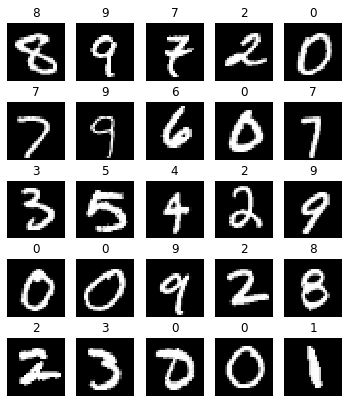

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

С темпом обучения 0.01 сеть не училась, поэтому я взял 0.1

Также я создал функцию learn, так как в дальнейшем она будет часто применяться

In [15]:
def learn(epochs, activation):

    layers = [Linear(784, 100), activation,
              Linear(100, 100), activation,
              Linear(100, 10)]

    nn = NeuralNetwork(layers)
    
    criterion = NLLLoss()

    all_losses = []
    for epoch in range(epochs):
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        for X, y in train_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy() 

            output = nn.forward(X)
            loss = criterion.forward(output, y)
            dLdy = criterion.backward()
            print(f'\r current loss {loss}', end='')

            all_losses.append(loss)

            nn.backward(dLdy)

            nn.step(0.1)
    return nn, all_losses

In [16]:
neuralSigmoid, all_losses = learn(2, Sigmoid())

 current loss 0.52448314157971626

График обучения на обучающей выборке, 2 эпохи

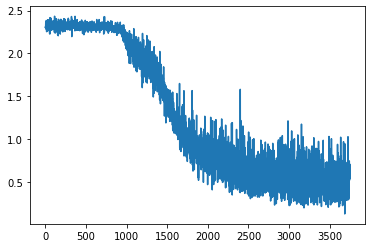

In [17]:
plt.plot(np.array(all_losses))

График обучения на тестовой выборке, 5 эпох

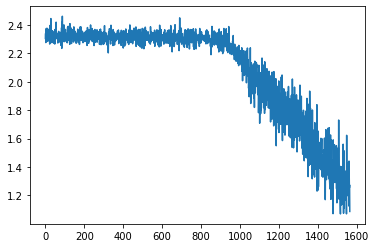

In [13]:
plt.plot(np.array(all_losses))

Точность классификации так же вынесем в отдельную функцию

In [57]:
def precision(nn):
    sum_all = 0
    sum_correct = 0
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy() 
        output = nn.forward(X)
        output = np.exp(output)
        ans = output.argmax(axis=1)
        ans = (ans == y)
        sum_all += 32
        sum_correct += ans.sum()
    return sum_correct/sum_all

In [19]:
precision(neuralSigmoid)

0.8606230031948882


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [20]:
class Relu:
    def __init__(self):
        pass

    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)

    def backward(self, dLdy):    
        return dLdy * (self.x > 0)

    def step(self, learning_rate):
        pass

In [21]:
class Elu:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def forward(self, x):
        self.x = x
        x = x.astype(float)
        ind = np.where(x <= 0)
        x[ind] = self.alpha*(np.exp(x[ind]) - 1)
        return x
    
    def backward(self, dLdy):
        b = self.x.astype(float)
        ind = np.where(b <= 0)
        ind2 = np.where(b > 0)
        b[ind] = self.alpha*np.exp(b[ind])
        b[ind2] = 1
        return b * dLdy
    
    def step(self, learning_rate):
        pass

In [22]:
neuralRelu, all_losses = learn(1, Relu())

 current loss 0.206843110915791334

График обучения с ReLU

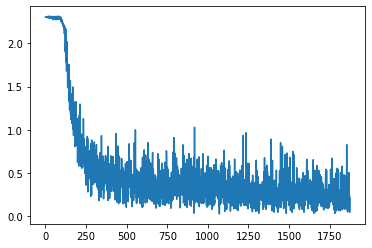

In [23]:
plt.plot(np.array(all_losses))

Точность классификации с ReLU

In [24]:
precision(neuralRelu)

0.9271166134185304


In [25]:
neuralElu, all_losses = learn(1, Elu(1))

 current loss 0.325570661929699146

График обучения с ELU

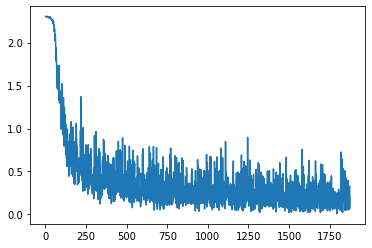

In [26]:
plt.plot(np.array(all_losses))

Точность классификации с ELU

In [27]:
precision(neuralElu)

0.9396964856230032


Одной эпохи хватает и с ReLU, и с ELU

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

Вынесем ошибки на батче в отдельную функцию

In [28]:
def errors(nn): 
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy() 

        predictions = nn.forward(X)

        predictions = np.exp(predictions)
        predictions = predictions / np.sum(predictions, axis=-1).reshape(-1, 1)

        prob = predictions[np.arange(y.shape[0]), y]

        #ind = np.where(prob < 0.7)
        ind = np.argsort(prob)[:25]

        plt.figure(figsize=(6, 7))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(X[ind[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.title("%d(%d) - %.2f" % (np.argmax(predictions[ind[i], :]), y[ind[i]], prob[ind[i]]))
            plt.axis('off')    

        break

Ошибки с Sigmoid

In [29]:
neuralSigmoid, _ = learn(2, Sigmoid())

 current loss 0.39555896504047366

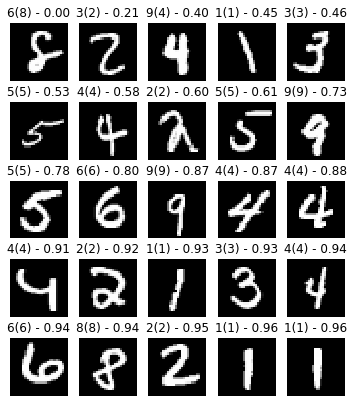

In [30]:
errors(neuralSigmoid)

Ошибки с ReLU

In [31]:
neuralRelu, _ = learn(1, Relu())

 current loss 0.106702152589803976

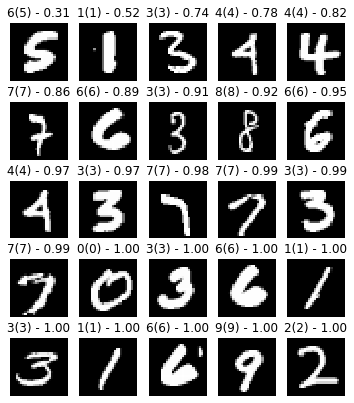

In [32]:
errors(neuralRelu)

Ошибки с ELU

In [33]:
neuralElu, _ = learn(1, Elu(1))

 current loss 0.076778134476139436

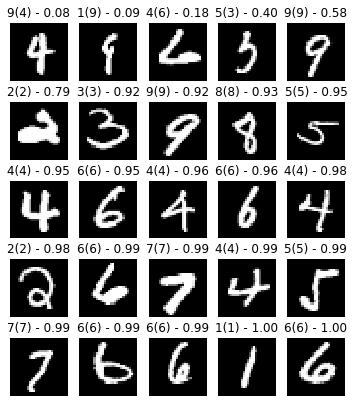

In [34]:
errors(neuralElu)

### HW1 (1 балл): Реализовать Tanh

In [35]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, x):
        self.x = x
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def backward(self, dLdy):
        der = 4/((np.exp(self.x) + np.exp(-self.x)) ** 2)
        return dLdy * der

    def step(self, learning_rate):
        pass

In [36]:
neuralTanh, all_losses = learn(1, Tanh())

 current loss 0.095146379010159435

График обучения с Tanh

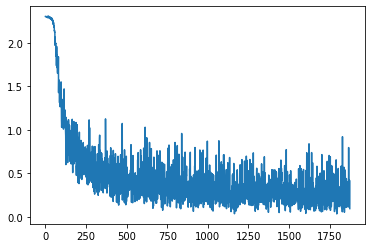

In [37]:
plt.plot(np.array(all_losses))

Точность классификации с Tanh

In [38]:
precision(neuralTanh)

0.9202276357827476


Ошибки с Tanh

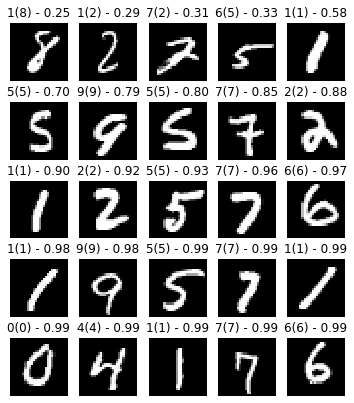

In [39]:
errors(neuralTanh)

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Немного модифицируем функцию learn

In [40]:
from scipy.ndimage import rotate

In [49]:
def learn(epochs, activation, rotates=0, moves=0, noises=0):

    layers = [Linear(784, 100), activation,
              Linear(100, 100), activation,
              Linear(100, 10)]

    nn = NeuralNetwork(layers)
    
    criterion = NLLLoss()

    all_losses = []
    for epoch in range(epochs):
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        for X, y in train_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()
            
            
            if noises > 0:
                noise = np.zeros((noises, X.shape[1]))
                for i in range(noises):
                    r = np.random.randint(low=0, high=32)
                    noise[i] = X[r] + np.random.random((28*28))
                    y = np.append(y, y[r])
                X = np.vstack((X, noise))
                
                
            if moves > 0:
                move = np.zeros((moves, X.shape[1]))
                for i in range(moves):
                    r = np.random.randint(low=0, high=32)
                    move[i] = np.roll(X[r],
                                      np.random.randint(low=-3, high=3))
                    y = np.append(y, y[r])
                X = np.vstack((X, move))
                
            if rotates > 0:
                rot = np.zeros((rotates, X.shape[1]))
                for i in range(rotates):
                    r = np.random.randint(low=0, high=32)
                    angle = -15
                    if i > rotates//2:
                        angle = 15
                    rot[i] = rotate(X[r].reshape(28, 28), angle)[3:31:, 3:31:].flatten()
                    y = np.append(y, y[r])
                X = np.vstack((X, rot))

            output = nn.forward(X)
            loss = criterion.forward(output, y)
            dLdy = criterion.backward()
            print(f'\r current loss {loss}', end='')

            all_losses.append(loss)

            nn.backward(dLdy)

            nn.step(0.1)
    return nn, all_losses

Будем добавлять по три аугментированных картинки из разных категорий и смотреть, как меняется точность. Вынесем в отдельную функцию, чтобы потом сделать то же самое с другими нелинейностями

In [64]:
def choose_aug(epochs, activation):
    params = []
    precs = []
    for noises in [0, 3]:
        for moves in [0, 3]:
            for rotates in [0, 3]:
                print(f'noises = {noises}, moves = {moves}, rotates = {rotates}')
                neuN, _ = learn(epochs, activation, noises=noises, moves=moves, rotates=rotates)
                precs.append(precision(neuN))
                print(f'\nprecision {precs[-1]}')
                params.append((noises, moves, rotates))
    params = np.array(params)
    precs = np.array(precs)
    return precs, params

In [65]:
precs, params = choose_aug(2, Sigmoid())

noises = 0, moves = 0, rotates = 0
 current loss 0.39251677426753223
precision 0.8650159744408946
noises = 0, moves = 0, rotates = 3
 current loss 0.42052009670382007
precision 0.8553314696485623
noises = 0, moves = 3, rotates = 0
 current loss 0.51765508296279635
precision 0.862220447284345
noises = 0, moves = 3, rotates = 3
 current loss 0.55393372046597584
precision 0.8478434504792333
noises = 3, moves = 0, rotates = 0
 current loss 0.78649237744506572
precision 0.8664137380191693
noises = 3, moves = 0, rotates = 3
 current loss 0.45372237305809654
precision 0.8746006389776357
noises = 3, moves = 3, rotates = 0
 current loss 0.70392677731466295
precision 0.858526357827476
noises = 3, moves = 3, rotates = 3
 current loss 0.62705681131853366
precision 0.8563298722044729


In [66]:
print(params[precs.argsort()[::-1]])

[[3 0 3]
 [3 0 0]
 [0 0 0]
 [0 3 0]
 [3 3 0]
 [3 3 3]
 [0 0 3]
 [0 3 3]]


In [68]:
print(precs.max())

0.8746006389776357


Как мы видим нейронная сеть с Sigmoid лучше всего обучается, когда есть шум и вращения

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Уже сравнил выше, теперь выберем лучший набор аугментаций для Relu, Elu и Tanh

In [69]:
precs, params = choose_aug(1, Relu())

noises = 0, moves = 0, rotates = 0
 current loss 0.381788973155669066
precision 0.919029552715655
noises = 0, moves = 0, rotates = 3
 current loss 0.359938918131054946
precision 0.9153354632587859
noises = 0, moves = 3, rotates = 0
 current loss 0.317780027512940674
precision 0.926417731629393
noises = 0, moves = 3, rotates = 3
 current loss 0.248688419005465986
precision 0.9276158146964856
noises = 3, moves = 0, rotates = 0
 current loss 0.293701331987844765
precision 0.9187300319488818
noises = 3, moves = 0, rotates = 3
 current loss 0.423373594007866366
precision 0.9107428115015974
noises = 3, moves = 3, rotates = 0
 current loss 0.22803967742583825
precision 0.9253194888178914
noises = 3, moves = 3, rotates = 3
 current loss 0.207680751757036185
precision 0.9234225239616614


In [70]:
print(params[precs.argsort()[::-1]]) # Лучший набор аугментаций

[[0 3 3]
 [0 3 0]
 [3 3 0]
 [3 3 3]
 [0 0 0]
 [3 0 0]
 [0 0 3]
 [3 0 3]]


In [71]:
print(precs.max()) # Точность с лучшим набором аугментаций

0.9276158146964856


In [72]:
precs, params = choose_aug(1, Elu(1))

noises = 0, moves = 0, rotates = 0
 current loss 0.093066845915746027
precision 0.9396964856230032
noises = 0, moves = 0, rotates = 3
 current loss 0.166104418468404464
precision 0.9408945686900958
noises = 0, moves = 3, rotates = 0
 current loss 0.294963565547025465
precision 0.9388977635782748
noises = 0, moves = 3, rotates = 3
 current loss 0.156161568645535438
precision 0.9457867412140575
noises = 3, moves = 0, rotates = 0
 current loss 0.416707381042516756
precision 0.9325079872204473
noises = 3, moves = 0, rotates = 3
 current loss 0.182480334249403686
precision 0.9396964856230032
noises = 3, moves = 3, rotates = 0
 current loss 0.124368736460419536
precision 0.9423921725239617
noises = 3, moves = 3, rotates = 3
 current loss 0.481665435070958916
precision 0.9244209265175719


In [73]:
print(params[precs.argsort()[::-1]])

[[0 3 3]
 [3 3 0]
 [0 0 3]
 [3 0 3]
 [0 0 0]
 [0 3 0]
 [3 0 0]
 [3 3 3]]


In [74]:
print(precs.max())

0.9457867412140575


In [75]:
precs, params = choose_aug(1, Tanh())

noises = 0, moves = 0, rotates = 0
 current loss 0.347838089492607645
precision 0.9205271565495208
noises = 0, moves = 0, rotates = 3
 current loss 0.125403165474617946
precision 0.9213258785942492
noises = 0, moves = 3, rotates = 0
 current loss 0.298436128515418755
precision 0.9106429712460063
noises = 0, moves = 3, rotates = 3
 current loss 0.177958910802611864
precision 0.922923322683706
noises = 3, moves = 0, rotates = 0
 current loss 0.364575075214610644
precision 0.9233226837060703
noises = 3, moves = 0, rotates = 3
 current loss 0.16018118765469577
precision 0.9239217252396166
noises = 3, moves = 3, rotates = 0
 current loss 0.11337159358936627
precision 0.9270167731629393
noises = 3, moves = 3, rotates = 3
 current loss 0.30079662464541937
precision 0.9178314696485623


In [76]:
print(params[precs.argsort()[::-1]])

[[3 3 0]
 [3 0 3]
 [3 0 0]
 [0 3 3]
 [0 0 3]
 [0 0 0]
 [3 3 3]
 [0 3 0]]


In [77]:
print(precs.max())

0.9270167731629393


### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

ReLU, ELU и Tanh сходятся заметно быстрее чем Sigmoid (для которой пришлось даже проводить две эпохи, так как на одной она недообучалась). Также они дают заметный качественный прирост.

Аугментации помогают в зависимости от алгоритма. В основном полезными оказались вращения и сдвиги, хотя шумы тоже иногда давали прирост точности. Аугментации несущественно уменьшают скорость сходимости (увеличивают сложность одного шага), так как немного увеличивают батч.

Лучшая модель - нелинейность ELU с вращениями и сдвигами в качестве предобработки, максимальная точность 0.9457867412140575